## Загрузка датасета

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/Diplom2024/Code/dataset

/content/drive/My Drive/Colab Notebooks/Diplom2024/Code/dataset


In [3]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd


In [4]:
dataset = pd.read_csv("syscalls_dataset.csv")

In [5]:
dataset

,last syscalls,syscall
0,"kwin_x11syscallreadsyscall(5, ""\1\0\0\0\0\0\0\...","kwin_x11syscallwritevsyscall(3, [{iov_base=""\2..."
1,_opt_google_chrome_chromesyscallepoll_waitsysc...,_opt_google_chrome_chromesyscallsendtosyscall(...
2,"_usr_lib_xorg_Xorgsyscallwritevsyscall(103, [{...","_usr_lib_xorg_Xorgsyscallwritevsyscall(103, [{..."
3,"_usr_lib_xorg_Xorgsyscallioctlsyscall(18, DRM_...","_usr_lib_xorg_Xorgsyscallreadsyscall(18, ""\2\0..."
4,_opt_google_chrome_chromesyscallepoll_waitsysc...,_opt_google_chrome_chromesyscallepoll_waitsysc...
...,...,...
366027,"chromesyscallepoll_waitsyscall(29, [{events=EP...","chromesyscallsendtosyscall(106, ""\10\0\0\0h\0\..."
366028,"at-spi2-registrsyscallrecvmsgsyscall(5, {msg_n...","at-spi2-registrsyscallrecvmsgsyscall(5, {msg_n..."
366029,"Xorgsyscallrecvmsgsyscall(53, {msg_name=NULL, ...","Xorgsyscallioctlsyscall(20, DRM_IOCTL_I915_GEM..."
366030,"Xorgsyscallrecvmsgsyscall(86, {msg_namelen=0},...","Xorgsyscallwritevsyscall(86, [{iov_base=""\1\0v..."


In [6]:
from sklearn.utils import shuffle

dataset = shuffle(dataset)

In [7]:
dataset

,last syscalls,syscall
69976,"_usr_lib_xorg_Xorgsyscallrecvmsgsyscall(54, {m...","_usr_lib_xorg_Xorgsyscallrecvmsgsyscall(97, {m..."
162480,"Xorgsyscallepoll_waitsyscall(3, [{events=EPOLL...","Xorgsyscallsetitimersyscall(ITIMER_REAL, {it_i..."
197217,"acpidsyscallrt_sigprocmasksyscall(SIG_BLOCK, [...","acpidsyscallrt_sigprocmasksyscall(SIG_UNBLOCK,..."
28651,"_usr_lib_xorg_Xorgsyscallwritevsyscall(54, [{i...","_usr_lib_xorg_Xorgsyscallrecvmsgsyscall(54, {m..."
19139,"javasyscallrecvmsgsyscall(20, {msg_name=NULL, ...","javasyscallrecvmsgsyscall(20, {msg_namelen=0},..."
...,...,...
95842,_usr_lib_xorg_Xorgsyscallsetitimersyscall(ITIM...,"_usr_lib_xorg_Xorgsyscallrecvmsgsyscall(97, {m..."
304031,"_usr_lib_xorg_Xorgsyscallrecvmsgsyscall(54, {m...",_usr_lib_xorg_Xorgsyscallsetitimersyscall(ITIM...
75839,"chromesyscallrecvmsgsyscall(32, {msg_namelen=0...","chromesyscallfutexsyscall(0x7f444b7f5458, FUTE..."
126118,"Xorgsyscallsetitimersyscall(ITIMER_REAL, {it_i...","Xorgsyscallepoll_waitsyscall(3, [{events=EPOLL..."


## Выбор девайса

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [9]:
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import torch
from torch.nn import Embedding, Linear, LSTM, Module, Sigmoid, Tanh
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm
import re
import time

## Разбиение данных на токены

In [10]:
import re

def tokenizer(syscalls):
    syscalls = syscalls.split(sep='last_n_syscalls')
    tokens = []
    for syscall in syscalls:
        str = syscall.split(sep='syscall')
        str = [s if len(s) > 0 else '<pad>' for s in str]
        # tokens.extend(['command', str[0], 'syscallname', str[1], 'syscallargs', str[2], 'syscallres', str[3], 'syscallend'])
        tokens.extend([str[0], str[1], str[2], str[3]])
        # tokens.extend([str[0], str[1], str[2], str[3], 'syscallend'])

    return tokens

## Преобразование токены в коды

In [11]:
from collections import Counter

In [12]:
def token_to_sequence(tokens, token2index):
    seq = []
    for token in tokens:
        index = token2index.get(token, len(token2index) - 1) # len(token2index) - 1 означает неизвестное слово
        seq.append(index)

    return seq

## Класс данных системных вызовов для обучения

In [13]:
class SyscallDataset(Dataset):
    def __init__(self, dataset, token_size):
        self.dataset = dataset

        # Разбиваем системные вызовы на токены
        self.last_syscalls_tokens = [tokenizer(self.dataset.iloc[i]['last syscalls']) for i in range(len(self.dataset))]
        self.syscall_tokens = [tokenizer(self.dataset.iloc[i]['syscall']) for i in range(len(self.dataset))]

        # Все токены встретившихся системных вызовов
        # syscalls_names = [last_syscall[j+3] for last_syscall in self.last_syscalls_tokens
        #                       for j in [*range(len(last_syscall))][::len(self.syscall_tokens[0])]]

        # syscalls_names.extend([syscall[3] for syscall in self.syscall_tokens])


        syscalls_names = [last_syscall[j+1] for last_syscall in self.last_syscalls_tokens
                              for j in [*range(len(last_syscall))][::len(self.syscall_tokens[0])]]

        syscalls_names.extend([syscall[1] for syscall in self.syscall_tokens])

        # Все токены встретившихся команд
        # command_names = [last_syscall[j+1] for last_syscall in self.last_syscalls_tokens
        #                       for j in [*range(len(last_syscall))][::len(self.syscall_tokens[0])]]

        # command_names.extend([syscall[1] for syscall in self.syscall_tokens])

        command_names = [last_syscall[j] for last_syscall in self.last_syscalls_tokens
                              for j in [*range(len(last_syscall))][::len(self.syscall_tokens[0])]]

        command_names.extend([syscall[0] for syscall in self.syscall_tokens])

        # Индексируем встречающиеся названия системных вызовов по их встречаемости
        tokens_counter = Counter(syscalls_names)

        most_common_token2index = {
            token[0]: i
            for i, token in enumerate(tokens_counter.most_common())
        }

        # Все названия встретившихся системных вызовов
        self.syscalls_name = list(tokens_counter.keys())


        # Добавление токенов названий команд для индексации
        tokens_counter = Counter(command_names)

        most_common_token2index.update({
            token[0]: i + len(self.syscalls_name)
            for i, token in enumerate(tokens_counter.most_common())
        })

        # Все названия встретившихся команд
        self.сommands_name = list(tokens_counter.keys())


        # Добавление оставшихся токенов для индексации
        tokens_counter = Counter()

        for syscalls_token in self.last_syscalls_tokens:
            for token in syscalls_token:
                if token not in self.syscalls_name and token not in self.сommands_name:
                    tokens_counter.update({token: 1})

        most_common_token2index.update({
            token[0]: i + len(self.syscalls_name) + len(self.сommands_name)
            for i, token in enumerate(tokens_counter.most_common()[:(token_size - 2 - len(self.syscalls_name) - len(self.сommands_name))])
        })


        # Словарь, отображающий токены в коды
        self.token2index = dict()
        # Словарь, отображающий коды в токены
        self.index2token = dict()


        self.token2index.update(most_common_token2index)
        self.token2index.update({"<pad>": len(self.token2index), "<unk>": len(self.token2index) + 1})

        self.index2token = {v: k for k, v in self.token2index.items()}

        self.token_size = min(len(self.index2token), token_size)

        self.vocabulary = [self.index2token[i] for i in range(len(self.syscalls_name))]


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, ix):
        X = torch.LongTensor(
            token_to_sequence(self.last_syscalls_tokens[ix], self.token2index)
        )

        y = token_to_sequence(self.syscall_tokens[ix], self.token2index)

        # return X, y[3]
        return X, y[1]


## Класс нейронной сети системных вызовов

In [52]:
class SyscallNetwork(Module):
    def __init__(
        self,
        token_size,
        syscalls_name_len,
        embedding_dim=2,
        hidden_dim_2=32,
        max_norm=2,
    ):
        super().__init__()

        self.embedding = Embedding(
                token_size,
                embedding_dim,
                padding_idx=0,
                norm_type=2,
                max_norm=max_norm,
        )

        # self.linear_1 = Linear(9 * 5 * embedding_dim, hidden_dim_2)
        self.linear_1 = Linear(4 * 5 * embedding_dim, hidden_dim_2)
        # self.linear_1 = Linear(5 * 5 * embedding_dim, hidden_dim_2)
        self.sigmoid = Sigmoid()
        self.linear_2 = Linear(hidden_dim_2, syscalls_name_len)

        self.linear = Linear(4 * 5 * embedding_dim, syscalls_name_len)


    def forward(self, x):
        emb = self.embedding(x)  # (n_samples, 45, 2)
        emb = emb.reshape(x.shape[0], -1)

        # x = self.linear_1(emb)
        # x = self.sigmoid(x)
        # x = self.linear_2(x)

        x = self.linear(emb)

        return x


def compute_loss_accuracy_perfomance(loss, net, dataloader):
    net.eval()
    all_losses = []
    all_accuracy = []
    all_perfomance = 0

    for X_batch, y_batch in dataloader:
        time_start = time.time_ns()
        pred = net(X_batch)
        time_end = time.time_ns()
        all_perfomance += (time_end - time_start)

        all_losses.append(loss(pred, y_batch).item())

        pred = pred.argmax(dim=1)
        all_accuracy.append((pred == y_batch).float().mean())

    return np.mean(all_losses), np.mean(all_accuracy), (all_perfomance // len(dataloader.sampler.indices))


#### Задание гиперпараметров

In [91]:
token_size = 500 # максимальное количество токенов
embedding_dim = 4
hidden_dim_2 = 4
max_norm = 2

n_epochs = 25
train_split = 0.7
val_split = 0.1
batch_size = 1024

#### Функция потерь

In [39]:
loss_f = torch.nn.CrossEntropyLoss()

## Создание тренировочного и валидационного датасета

In [17]:
syscalldataset = SyscallDataset(dataset, token_size)


n_samples = len(dataset)
train_ix = int(n_samples * train_split)
val_ix = int(n_samples * val_split) + train_ix

train_indices, val_indices, test_indices = np.arange(train_ix), np.arange(train_ix, val_ix), np.arange(val_ix, n_samples)

train_dataloader = DataLoader(
        syscalldataset, sampler=SubsetRandomSampler(train_indices),
        batch_size=batch_size
)
val_dataloader = DataLoader(
        syscalldataset, sampler=SubsetRandomSampler(val_indices),
        batch_size=batch_size
)
test_dataloader = DataLoader(
        syscalldataset, sampler=SubsetRandomSampler(test_indices),
        batch_size=batch_size
)

## Создание нейронной сети и оптимайзера


In [92]:
net = SyscallNetwork(
        syscalldataset.token_size,
        len(syscalldataset.syscalls_name),
        hidden_dim_2=hidden_dim_2,
        embedding_dim=embedding_dim,
        max_norm=max_norm,
)

optimizer = torch.optim.Adam(
        net.parameters(),
        lr=1e-2,
)


## Обучение нейронной сети и сохранение лучшей модели

In [93]:
emb_history = []
val_accuracy_history = []
val_loss_history = []
val_perfomance_history = []
train_loss_history = []
best_val_acc = 0.0

for epoch in range(n_epochs):
    net.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        pred = net(X_batch)
        loss = loss_f(pred, y_batch)
        loss.backward()

        optimizer.step()


    if epoch % 1 == 0 or epoch == n_epochs:
        train_loss, _, _= compute_loss_accuracy_perfomance(loss_f, net, train_dataloader)
        val_loss, val_acc, val_perf = compute_loss_accuracy_perfomance(loss_f, net, val_dataloader)
        print(f"Epoch: {epoch}, train loss: {train_loss=:.3f}, validation loss {val_loss=:.3f}")
        print(f'Perfomance {val_perf}')
        print(f'Accuracy: {val_acc}')
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_acc)
        val_perfomance_history.append(val_perf)

        if (val_acc > best_val_acc):
            best_val_acc = val_acc
            torch.save(net.state_dict(), 'best-model-syscall-prediction.pt')


    # Prepare DataFrame

    weights = net.embedding.weight.detach().clone().numpy()[:len(syscalldataset.vocabulary)]

    df = pd.DataFrame(weights, columns=[f"dim_{i}" for i in range(embedding_dim)])
    df["epoch"] = epoch
    df["token"] = syscalldataset.vocabulary


    emb_history.append(df)

final_df = pd.concat(emb_history)
final_df.to_csv("emb.csv", index=False)

100%|██████████| 501/501 [00:08<00:00, 62.04it/s]


Epoch: 0, train loss: train_loss=0.653, validation loss val_loss=0.672
Perfomance 3013
Accuracy: 0.8007510900497437


100%|██████████| 501/501 [00:09<00:00, 55.54it/s]


Epoch: 1, train loss: train_loss=0.604, validation loss val_loss=0.624
Perfomance 2851
Accuracy: 0.8135885000228882


100%|██████████| 501/501 [00:09<00:00, 54.92it/s]


Epoch: 2, train loss: train_loss=0.586, validation loss val_loss=0.609
Perfomance 2872
Accuracy: 0.8161612749099731


100%|██████████| 501/501 [00:08<00:00, 59.05it/s]


Epoch: 3, train loss: train_loss=0.574, validation loss val_loss=0.598
Perfomance 4465
Accuracy: 0.8180372714996338


100%|██████████| 501/501 [00:06<00:00, 72.09it/s]


Epoch: 4, train loss: train_loss=0.565, validation loss val_loss=0.588
Perfomance 2889
Accuracy: 0.8220357298851013


100%|██████████| 501/501 [00:07<00:00, 70.45it/s]


Epoch: 5, train loss: train_loss=0.560, validation loss val_loss=0.588
Perfomance 3038
Accuracy: 0.823157787322998


100%|██████████| 501/501 [00:07<00:00, 65.17it/s]


Epoch: 6, train loss: train_loss=0.559, validation loss val_loss=0.586
Perfomance 2871
Accuracy: 0.8228452205657959


100%|██████████| 501/501 [00:08<00:00, 61.76it/s]


Epoch: 7, train loss: train_loss=0.554, validation loss val_loss=0.582
Perfomance 2890
Accuracy: 0.8267796635627747


100%|██████████| 501/501 [00:08<00:00, 56.94it/s]


Epoch: 8, train loss: train_loss=0.545, validation loss val_loss=0.575
Perfomance 3917
Accuracy: 0.8263087868690491


100%|██████████| 501/501 [00:08<00:00, 60.02it/s]


Epoch: 9, train loss: train_loss=0.543, validation loss val_loss=0.574
Perfomance 5073
Accuracy: 0.8290485739707947


100%|██████████| 501/501 [00:08<00:00, 61.56it/s]


Epoch: 10, train loss: train_loss=0.543, validation loss val_loss=0.573
Perfomance 2851
Accuracy: 0.8253897428512573


100%|██████████| 501/501 [00:07<00:00, 63.84it/s]


Epoch: 11, train loss: train_loss=0.541, validation loss val_loss=0.572
Perfomance 3943
Accuracy: 0.8306523561477661


100%|██████████| 501/501 [00:09<00:00, 55.66it/s]


Epoch: 12, train loss: train_loss=0.540, validation loss val_loss=0.569
Perfomance 2909
Accuracy: 0.8292699456214905


100%|██████████| 501/501 [00:08<00:00, 60.14it/s]


Epoch: 13, train loss: train_loss=0.537, validation loss val_loss=0.571
Perfomance 2964
Accuracy: 0.8293859958648682


100%|██████████| 501/501 [00:08<00:00, 61.98it/s]


Epoch: 14, train loss: train_loss=0.537, validation loss val_loss=0.569
Perfomance 4530
Accuracy: 0.8297603726387024


100%|██████████| 501/501 [00:06<00:00, 72.40it/s]


Epoch: 15, train loss: train_loss=0.534, validation loss val_loss=0.570
Perfomance 2950
Accuracy: 0.8305232524871826


100%|██████████| 501/501 [00:07<00:00, 70.29it/s]


Epoch: 16, train loss: train_loss=0.532, validation loss val_loss=0.568
Perfomance 3168
Accuracy: 0.8306826949119568


100%|██████████| 501/501 [00:07<00:00, 67.27it/s]


Epoch: 17, train loss: train_loss=0.538, validation loss val_loss=0.572
Perfomance 2872
Accuracy: 0.8292742967605591


100%|██████████| 501/501 [00:08<00:00, 56.56it/s]


Epoch: 18, train loss: train_loss=0.531, validation loss val_loss=0.564
Perfomance 3131
Accuracy: 0.8297300338745117


100%|██████████| 501/501 [00:09<00:00, 54.65it/s]


Epoch: 19, train loss: train_loss=0.533, validation loss val_loss=0.567
Perfomance 4376
Accuracy: 0.8310310244560242


100%|██████████| 501/501 [00:09<00:00, 52.18it/s]


Epoch: 20, train loss: train_loss=0.534, validation loss val_loss=0.570
Perfomance 2988
Accuracy: 0.8261460065841675


100%|██████████| 501/501 [00:08<00:00, 61.74it/s]


Epoch: 21, train loss: train_loss=0.537, validation loss val_loss=0.570
Perfomance 3134
Accuracy: 0.8265594244003296


100%|██████████| 501/501 [00:09<00:00, 54.18it/s]


Epoch: 22, train loss: train_loss=0.529, validation loss val_loss=0.562
Perfomance 2986
Accuracy: 0.8321312069892883


100%|██████████| 501/501 [00:08<00:00, 61.32it/s]


Epoch: 23, train loss: train_loss=0.529, validation loss val_loss=0.566
Perfomance 2960
Accuracy: 0.8287534713745117


100%|██████████| 501/501 [00:08<00:00, 61.54it/s]


Epoch: 24, train loss: train_loss=0.533, validation loss val_loss=0.568
Perfomance 4214
Accuracy: 0.8294283747673035


## Графики loss и accuracy

In [94]:
import matplotlib.pyplot as plt

### Train

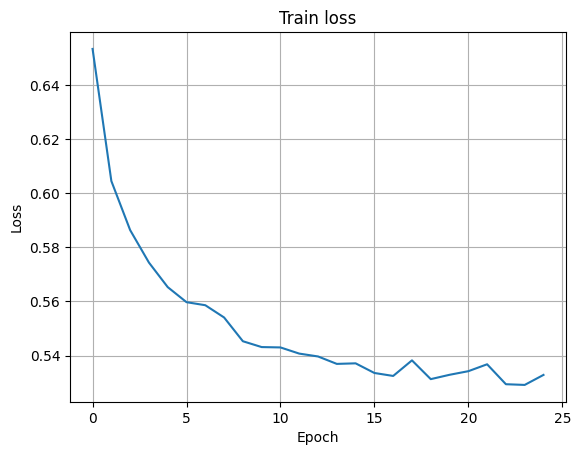

In [95]:
plt.title("Train loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(train_loss_history)

### Validation

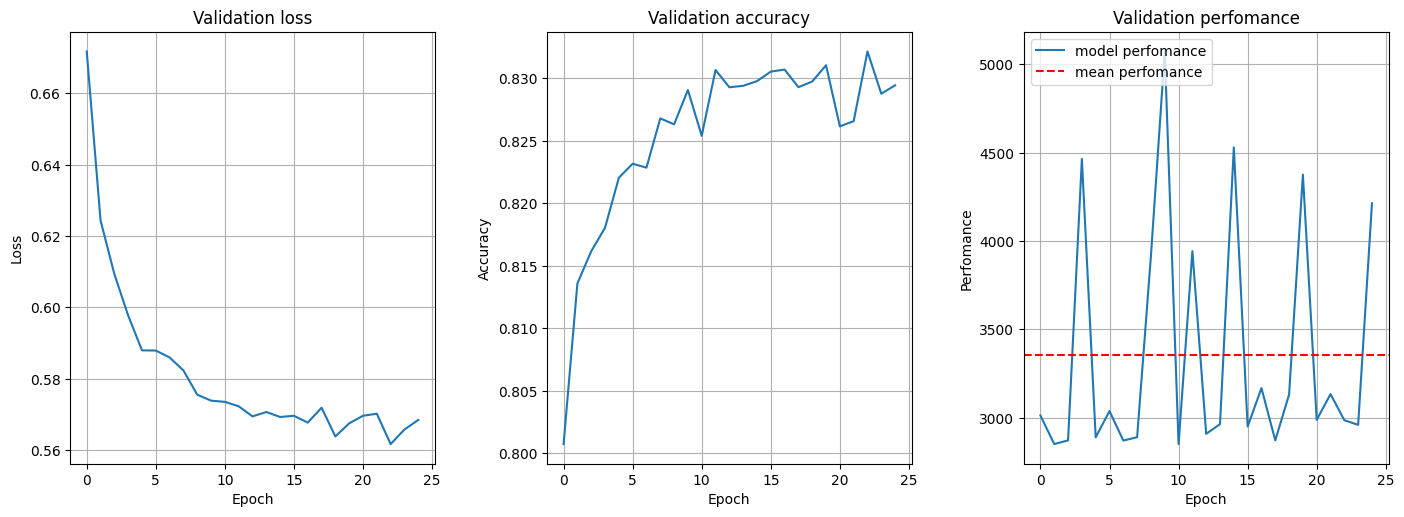

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.tight_layout(pad=5.0)

plt.subplot(1, 3, 1)
plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# plt.figure(figsize=(10,6))
plt.plot(val_loss_history)


plt.subplot(1, 3, 2)
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
# plt.figure(figsize=(10,6))
plt.plot(val_accuracy_history)

plt.subplot(1, 3, 3)
plt.title("Validation perfomance")
plt.xlabel('Epoch')
plt.ylabel('Perfomance')
plt.grid(True)
# plt.figure(figsize=(10,6))
plt.plot(val_perfomance_history, label='model perfomance')
plt.axhline(y=np.nanmean(val_perfomance_history), color='red', linestyle='--', label='mean perfomance')
plt.legend(loc="upper left")



In [97]:
print(np.nanmean(val_perfomance_history))

3354.2


### График embeddings

In [98]:
import plotly
import plotly.graph_objects as go
import plotly.express as px

In [99]:
df = pd.read_csv("emb.csv")

In [100]:
px.scatter(
    df,
    x='dim_0', y='dim_1',
    text = 'token',
    animation_frame='epoch',
    animation_group='token',
    # size='pop',
    # color='continent',
    hover_name='token'
    # log_x=True,
    # size_max=55,
    # range_x=[100, 100000], range_y=[25, 90]
)

### Результаты лучшей модели на тестовой выборке

In [101]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/Diplom2024/Code/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Diplom2024/Code/dataset


In [102]:
import torch

best_model = SyscallNetwork(
        syscalldataset.token_size,
        len(syscalldataset.syscalls_name),
        hidden_dim_2=hidden_dim_2,
        embedding_dim=embedding_dim,
        max_norm=max_norm,
)

best_model.load_state_dict(torch.load('best-model-syscall-prediction.pt'))
best_model.eval()

SyscallNetwork(
  (embedding): Embedding(500, 4, padding_idx=0, max_norm=2)
  (linear_1): Linear(in_features=80, out_features=4, bias=True)
  (sigmoid): Sigmoid()
  (linear_2): Linear(in_features=4, out_features=157, bias=True)
  (linear): Linear(in_features=80, out_features=157, bias=True)
)

In [103]:
test_loss, test_accuracy, test_perfomance = compute_loss_accuracy_perfomance(loss_f, best_model, test_dataloader)

In [104]:
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {int(test_accuracy * 100)}')
print(f'Test perfomance: {test_perfomance}')


Test loss: 0.560105270022279
Test accuracy: 83
Test perfomance: 3755


In [105]:
val_loss, val_accuracy, val_perfomance = compute_loss_accuracy_perfomance(loss_f, best_model, val_dataloader)

In [106]:
print(f'Test loss: {val_loss}')
print(f'Test accuracy: {int(val_accuracy * 100)}')
print(f'Test perfomance: {val_perfomance}')

Test loss: 0.5615229507287344
Test accuracy: 83
Test perfomance: 2956


In [107]:
train_loss, train_accuracy, train_perfomance = compute_loss_accuracy_perfomance(loss_f, best_model, train_dataloader)

In [108]:
print(f'Test loss: {train_loss}')
print(f'Test accuracy: {int(train_accuracy * 100)}')
print(f'Test perfomance: {train_perfomance}')

Test loss: 0.5295080024444176
Test accuracy: 83
Test perfomance: 2887
